In [55]:

import numpy as np
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from project.utils.transforms import DVSTransform
from project.utils.dvs_noises import EventDrop
from project.datamodules.fer_dvs import FerDVS


# Paramètres
timesteps = 6
data_dir = "data"  # Assurez-vous que ce répertoire existe et contient les données
transforms_list = ['flip', 'background_activity', 'crop', 'reverse', 'mirror', 'event_drop']




In [56]:
import numpy as np
import h5py
import torch
from torch.utils.data import Dataset, DataLoader
# Assurez-vous que les importations suivantes sont correctes selon votre structure de projet
from project.utils.transforms import DVSTransform
from project.utils.dvs_noises import EventDrop
from project.datamodules.fer_dvs import FerDVS
from project.fer_module import FerModule

# Votre code existant pour les paramètres, les importations et la définition du modèle...

class SingleH5FerDVS(Dataset):
    def __init__(self, h5_path, transform=None):
        self.transform = transform
        with h5py.File(h5_path, 'r') as file:
            raw_events = file['events'][:]  # Vérifiez que 'events' est la bonne clé
            self.data = self.structure_data(raw_events)

    def structure_data(self, raw_events):
        dtype = np.dtype([('x', np.int16), ('y', np.int16), ('p', np.bool_), ('t', np.int64)])
        structured_data = np.empty(raw_events.shape[0], dtype=dtype)

        # Assurez-vous que chaque champ est bien un tableau 1D
        structured_data['x'] = raw_events[:, 0].flatten()  # Utilisez flatten() pour garantir un array 1D
        structured_data['y'] = raw_events[:, 1].flatten()
        structured_data['p'] = raw_events[:, 2].astype(np.bool_).flatten()
        structured_data['t'] = raw_events[:, 3].flatten()

        return structured_data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
            event = self.data[idx]
            
            # Ajoutez une vérification pour vous assurer que 'event' n'est pas un scalaire
            if event.ndim == 0:  # 'ndim' donne le nombre de dimensions de 'event'
                raise IndexError(f"Attempted to index a 0-dimensional array. Event at index {idx} is a scalar.")

            if self.transform:
                event = self.transform(event)

            # Vérifiez si 'event' est un tableau NumPy avant la conversion en Tensor
            if isinstance(event, np.ndarray):
                event_tensor = torch.from_numpy(event).float()
            else:
                # Gestion des cas où 'event' n'est pas un tableau NumPy après la transformation
                event_tensor = torch.tensor(event, dtype=torch.float32)
            
            return event_tensor

# Votre code existant pour instancier le modèle, charger les données, etc...



In [57]:
from project.fer_module import FerModule

model = FerModule(
    learning_rate=0.005,  
    timesteps=6,
    n_classes=6,  
    epochs=1000,  
    mode="snn"
)


checkpoint_path = "C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\experiments\\CKPlusDVS_0\\version_31\\checkpoints\\0_epoch=717_val_acc=0.7324.ckpt"
model.load_from_checkpoint(checkpoint_path)
model.eval()

FerModule(
  (model): SNNModule(
    (encoder): MultiStepSEWResNet(
      (conv1): Conv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (sn1): MultiStepIFNode(
        v_threshold=1.0, v_reset=0.0, detach_reset=True, backend=torch
        (surrogate_function): ATan(alpha=2.0, spiking=True)
      )
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): MultiStepBasicBlock(
          cnf=ADD
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (sn1): MultiStepIFNode(
            v_threshold=1.0, v_reset=0.0, detach_reset=True, backend=torch
            (surrogate_function): ATan(alpha=2.0, spiking=True)
          )
          (conv2): Conv2d(6

In [61]:
import torch
import numpy as np
from torch.utils.data import Dataset, DataLoader
import h5py

class MultiH5Dataset(Dataset):
    def __init__(self, h5_paths, transform=None, data_per_file=None):
        self.h5_paths = h5_paths
        self.transform = transform
        self.data_per_file = data_per_file
        self.data = []
        self.load_data()

    def load_data(self):
        for h5_path in self.h5_paths:
            with h5py.File(h5_path, 'r') as file:
                events = np.array(file['events'])
                if self.data_per_file is not None:
                    events = events[:self.data_per_file]
                self.data.extend(events)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        event = self.data[idx]
        if self.transform:
            event = self.transform(event)
        event_tensor = torch.from_numpy(event.astype(np.float32))

        # Vérifiez et ajustez les dimensions pour correspondre aux attentes du modèle
        while event_tensor.dim() < 4:  # Assurez-vous d'avoir au moins (C, H, W)
            event_tensor = event_tensor.unsqueeze(0)

        # Dupliquez les canaux si nécessaire, par exemple, pour des données en niveaux de gris
        if event_tensor.size(1) == 1:  # Supposons que C est à l'indice 1
            event_tensor = event_tensor.repeat(1, 2, 1, 1)  # Répétez le canal pour obtenir 2 canaux

        return event_tensor

# Exemple d'utilisation
h5_paths = [
    "C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\data\\FerDVS\\CKPlusDVS\\S010\\006.h5",
    "C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\data\\FerDVS\\CKPlusDVS\\S010\\005.h5",
    "C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\data\\FerDVS\\CKPlusDVS\\S010\\004.h5",
    "C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\data\\FerDVS\\CKPlusDVS\\S010\\003.h5",
    "C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\data\\FerDVS\\CKPlusDVS\\S010\\002.h5",
    "C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\data\\FerDVS\\CKPlusDVS\\S010\\001.h5"
]  # Remplacez par vos chemins réels
dataset = MultiH5Dataset(h5_paths)
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

for batch in data_loader:
    output = model(batch)


In [65]:
output

tensor([[-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196],
        [-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196],
        [-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196],
        [-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196],
        [-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196],
        [-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196],
        [-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196],
        [-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196],
        [-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196],
        [-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196],
        [-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196],
        [-0.0079,  0.0188,  0.0175, -0.0201, -0.0348,  0.0196]],
       grad_fn=<MmBackward>)

In [63]:
import torch
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Video


classes = [
        "happy",
        "fear",
        "surprise",
        "anger",
        "disgust",
        "sadness",
    ]
# Appliquer Softmax pour obtenir des probabilités et ensuite prendre la valeur absolue (bien que généralement non nécessaire pour softmax)
probabilities = torch.abs(torch.softmax(output, dim=1))


# Obtenir les classes prédites
predicted_classes = torch.argmax(probabilities, dim=1)
predicted_classe = predicted_classes[0].item()


print("Classe prédite:\n", classes[predicted_classe])

Classe prédite:
 sadness


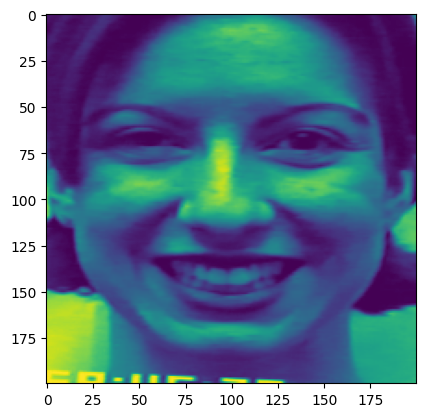

In [66]:
#afficher l'image correspondante

img = mpimg.imread("C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\data\\FerDVS\\CKPlusDVS\\S010\\006\\img_015.png")
imgplot = plt.imshow(img)
plt.show()
